In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate1 as sr1
import surrogate as sr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
warnings.filterwarnings('ignore')

**Uniform random feature experiments**

In [2]:
save_folder = f'../data/uniform-RF'
D, D_r = 3, 300
w, b = 0.4, 4
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
L0, L1 = 0.4, 3.5
percents = 50
n_repeats = 20000
n_models = percents * n_repeats
row_selection = 'uniform'
train_option = 'random_20000'
repo = '..'
L63_data_folder = '{}/data/L63-trajectories'.format(repo)
train = np.load('{}/train.npy'.format(L63_data_folder))
test = np.load('{}/test.npy'.format(L63_data_folder))
limits_W_in, limits_W = [-0.1, 0.1], [-.5, .5]

batch = sr1.BatchStrategy_SMLR(save_folder, D, D_r, n_repeats, beta, error_threshold, train, test[:1], dt, Lyapunov_time, L0, L1, percents,\
                          row_selection, train_option, limits_W_in, limits_W)
# batch.run_uniform(w, b, save_data=True)
bsa = sr1.BatchStrategyAnalyzer_SMLR(batch.save_folder)
# bsa.compute_train_loss(train)
# bsa.compute_test_loss_single(test)

**Histogram of phi**

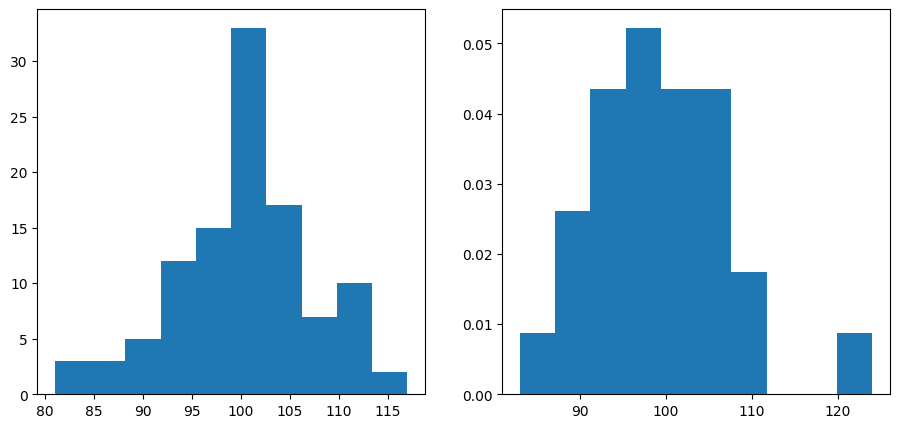

In [3]:
n = 1000
data = bsa.get_data()
phi_b, phi_g = [], []
threshold = 0.998
index_b, nature_b = data[data['tau_f_se'] < 0.5]['l'].to_numpy().astype(int), 'bad'
test_path = test[0,:, :1]
tau_f_b = []
tau_f_g = []

for i in index_b[:150]:
    model = bsa.get_model(i)
    f = np.abs(np.tanh(model.W_in @ test_path + model.b_in[:, np.newaxis]))
    phi_b.append((f < 0.9).sum())
    tau_f_b.append(data['tau_f_se'][i])

index_g, nature_g = data[data['tau_f_se'] > 6]['l'].to_numpy().astype(int), 'good' 
for i in index_g[:150]:
    model = bsa.get_model(i)
    f = np.abs(np.tanh(model.W_in @ test_path + model.b_in[:, np.newaxis]))
    phi_g.append((f < 0.9).sum())
    tau_f_g.append(data['tau_f_se'][i])

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
# ax.hist(phi_g, density=0)
# ax.hist(phi_b, density=0, alpha=0.7)
# ax.set_xlim(-0.1, 0)
# ax1.set_xlim(-0.1, 0)
ax.hist(phi_b)
ax1.hist(phi_g, density=1)
plt.show()

In [4]:
save_folder = '../data/bad-features-grid-1'
D, D_r = 3, 300
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
w_max, b_max = 0.4, 4.0
sqrt_n_models = 30
n_repeats = 100

L63_data_folder = '../data/L63-trajectories'
train = np.load('{}/train.npy'.format(L63_data_folder))
validation = np.load('{}/validation.npy'.format(L63_data_folder))#[:, :800]
batch = sr.BatchUniform_SMLR(save_folder, D, D_r, w_max, b_max, sqrt_n_models, beta, error_threshold, dt, Lyapunov_time)
# batch.run(train[:, :20000], n_repeats)

In [5]:
bsa = sr.BatchRunAnalyzer_SMLR(save_folder)
# bsa.compute_error(validation, rmse_threshold=np.sqrt(0.05))
# bsa.count(train[:, :10000], limits_in=[-0.1, 0.1], limits=[-0.5, 0.5], threshold=3.5)

KeyboardInterrupt: 

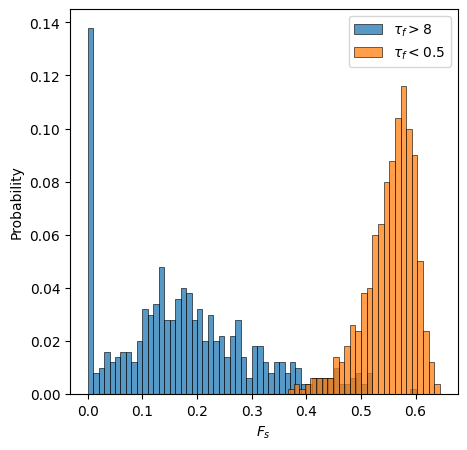

In [6]:
np.random.seed(42)
n, nbins, stat = 500, 100, 'probability'
data = bsa.get_data()
d_b = data[data['tau_f_se'] < 0.5]['avg_bad_features'].to_numpy()/D_r
index_b = np.random.choice(len(d_b), n, replace=False)
d_b = d_b[index_b]
dx_b = d_b.max() - d_b.min()
t_b = data[data['tau_f_se'] < 0.5]['tau_f_se'].to_numpy()[index_b]

d_g = data[data['tau_f_se'] > 8.0]['avg_bad_features'].to_numpy()/D_r
index_g = np.random.choice(len(d_g), n, replace=False)
d_g = d_g[index_g]
dx_g = d_g.max() - d_g.min()

t_g = data[data['tau_f_se'] > 8.0]['tau_f_se'].to_numpy()[index_g]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax1 = fig.add_subplot(122)
sns.histplot(d_g, ax=ax, stat=stat, label=r'$\tau_f>8$', bins=int(dx_g*nbins))
sns.histplot(d_b, ax=ax, stat=stat, label=r'$\tau_f<0.5$', bins=int(dx_b*nbins))
# sns.histplot(t_g, ax=ax1, stat=stat, bins=55)
# ax1.scatter(d_g, t_g, s=1)
# ax1.scatter(d_b, t_b, s=1)
ax.legend()
ax.set_xlabel(r'$F_s$')
# ax1.set_xlabel(r'$\tau_f$')
# ax1.set_title(r'$F_s=0$')
# fig.subplots_adjust(wspace=0.25)
plt.savefig('../data/plots/bad-fetaures-histogram.png', dpi=300)
plt.show()

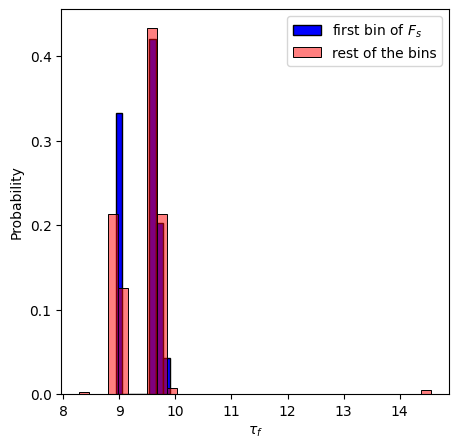

In [7]:
ft = np.array(sorted([(d_g[i],t_g[i]) for i in range(len(d_g))], key=lambda x:x[0]))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
sns.histplot(ft[:69, 1], color='blue', alpha=1., label=r'first bin of $F_s$', stat='probability', ax=ax)
sns.histplot(ft[69:, 1], color='red',  alpha=0.5, label='rest of the bins',  stat='probability', ax=ax)
ax.legend()
ax.set_xlabel(r'$\tau_f$')
plt.savefig('../data/plots/first-bin.png', dpi=300)

Time taken by get_mean_std is 0.2484 seconds


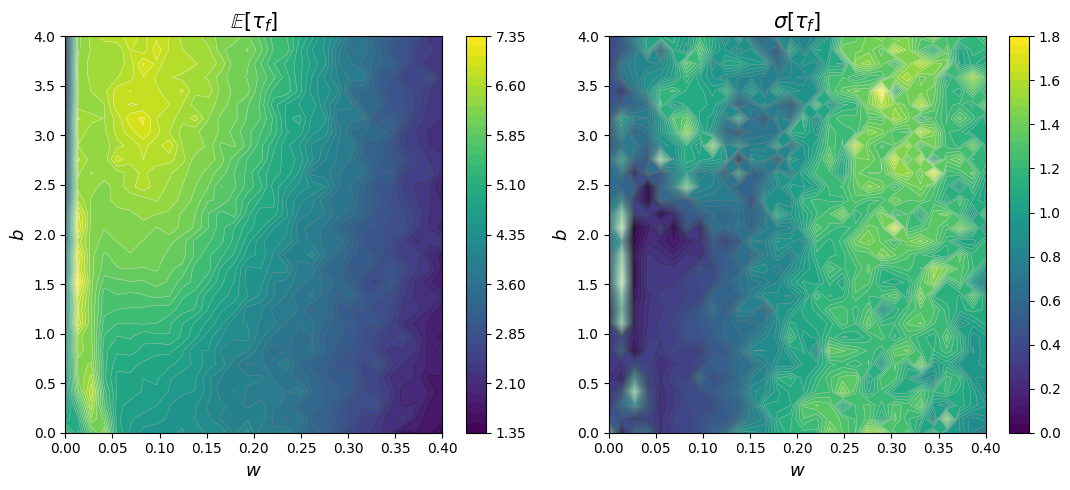

In [8]:
w = np.linspace(0., 0.4, num=30)
b = np.linspace(0., 4.0, num=30)
w, b = np.meshgrid(w, b)
tau, std = bsa.get_mean_std('tau_f_se')
fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
n = 50
im = ax.contourf(w, b, tau.T, n, cmap='viridis')
im_ = ax.contour(w, b, tau.T, n, cmap='Greys_r', linewidths=0.3)
fig.colorbar(im, ax=ax)
im1 = ax1.contourf(w, b, std.T, n, cmap='viridis')
im1_ = ax1.contour(w, b, std.T, n, cmap='Greys_r', linewidths=0.3)#, antialiased=True, nchunks=5)
fig.colorbar(im1, ax=ax1)
ax.set_xlabel(r'$w$', fontsize=13)
ax.set_ylabel(r'$b$', fontsize=13)
ax.set_title(r'$\mathbb{E}[\tau_f]$', fontsize=15)
ax1.set_xlabel(r'$w$', fontsize=13)
ax1.set_ylabel(r'$b$', fontsize=13)
ax1.set_title(r'$\sigma[\tau_f]$', fontsize=15)
plt.tight_layout()
plt.savefig(f'../data/plots/tau_f-heat-{n}.png', dpi=300)

**Plot $\mathbb{E}[\tau_f|x-a < F_s < x+a]$**

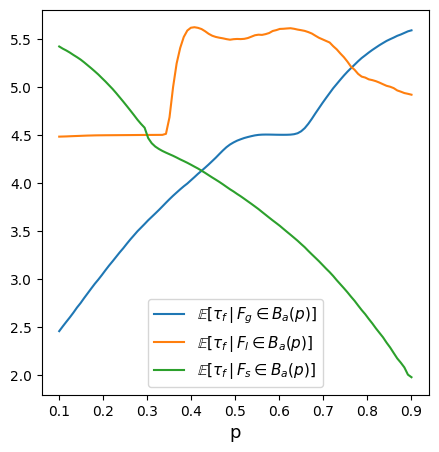

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
X = np.linspace(0.1, .9, num=100)
eps = 0.3
Ys = np.zeros_like(X)
Yl = np.zeros_like(X)
Yg = np.zeros_like(X)
for i, x in enumerate(X):
    Yg[i] = data[(data['avg_good_features']/D_r < x + eps) & (data['avg_good_features']/D_r > x-eps)]['tau_f_se'].mean()
    Yl[i] = data[(data['avg_linear_features']/D_r < x + eps) & (data['avg_linear_features']/D_r > x-eps)]['tau_f_se'].mean()
    Ys[i] = data[(data['avg_bad_features']/D_r < x + eps) & (data['avg_bad_features']/D_r > x-eps)]['tau_f_se'].mean()
# plt.scatter(X, Yg, marker='x')
ax.plot(X, Yg, label=r"$\mathbb{E}[\tau_f\,|\,F_g\in B_a(p)]$")
# ax.scatter(X, Yl, marker='x')
ax.plot(X, Yl, label=r"$\mathbb{E}[\tau_f\,|\,F_l\in B_a(p)]$")
# ax.scatter(X, Ys, marker='x')
ax.plot(X, Ys, label=r"$\mathbb{E}[\tau_f\,|\,F_s\in B_a(p)]$")
ax.legend(fontsize=11)
ax.set_xlabel('p', fontsize=13)
plt.savefig("../data/plots/tau_f_given_features.png", dpi=300, bbox_inches="tight")

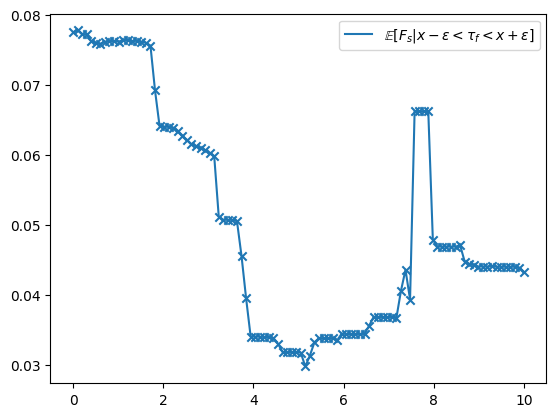

In [36]:
X = np.linspace(0, 10, num=100)
eps = 
Ys = np.zeros_like(X)
Yl = np.zeros_like(X)
Yg = np.zeros_like(X)
for i, x in enumerate(X):
    dat = data[(x-eps < data['tau_f_se']) & (data['tau_f_se'] < x+eps)]
    Yg[i] = dat['avg_good_features'].mean() / D_r
    Yl[i] = dat['avg_linear_features'].mean() / D_r
    Ys[i] = dat['avg_bad_features'].mean() / D_r
# plt.scatter(X, Yg, marker='x')
# plt.plot(X, Yg, label=r"$\mathbb{E}[F_g|x-\varepsilon < \tau_f < x+\varepsilon]$")
# plt.scatter(X, Yl, marker='x')
# plt.plot(X, Yl, label=r"$\mathbb{E}[F_l|x-\varepsilon < \tau_f < x+\varepsilon]$")
plt.scatter(X, Ys, marker='x')
plt.plot(X, Ys, label=r"$\mathbb{E}[F_s|x-\varepsilon < \tau_f < x+\varepsilon]$")
plt.legend()

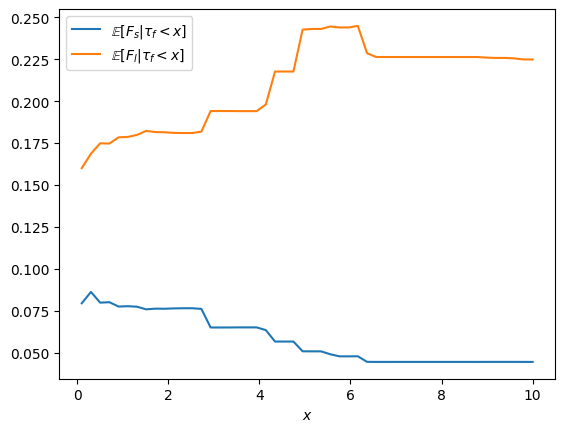

In [29]:
X = np.linspace(0.1, 10, num=50)
Ys = np.zeros_like(X)
Yl = np.zeros_like(X)
for i, x in enumerate(X):
    Ys[i] = data[data['tau_f_se'] < x]['avg_bad_features'].mean()/D_r
    Yl[i] = data[data['tau_f_se'] < x]['avg_linear_features'].mean()/D_r
plt.plot(X, Ys, label=r"$\mathbb{E}[F_s|\tau_f < x]$")
plt.plot(X, Yl, label=r"$\mathbb{E}[F_l|\tau_f < x]$")
plt.xlabel(r'$x$')
plt.legend()

In [21]:
data

,i,j,k,w,b,||W_in||,||b_in||,||W||,tau_f_rmse,tau_f_mse,tau_f_se,rmse,mse,se,0-rows-W_in,0-cols-W,avg_bad_features,avg_abs_col_sum_W,good_rows_W_in,avg_linear_features
0,0,0,0,0.013333,0.133333,0.228118,1.313164,204.081664,5.0596,5.0596,4.1678,0.906460,0.821669,0.821669,300,0,0.000,1298.823673,300,300.000
1,0,0,1,0.013333,0.133333,0.230146,1.304172,186.927193,6.3700,6.3700,4.9140,0.657714,0.432587,0.432587,300,1,0.000,1191.784577,300,300.000
2,0,0,2,0.013333,0.133333,0.237140,1.338860,191.845547,6.3700,6.3700,6.1516,0.821826,0.675397,0.675397,300,1,0.000,1246.103803,300,300.000
3,0,0,3,0.013333,0.133333,0.232286,1.303079,194.516886,6.3518,6.3518,6.1334,0.834164,0.695830,0.695830,300,0,0.000,1248.746216,300,300.000
4,0,0,4,0.013333,0.133333,0.234285,1.382001,187.469476,6.3154,6.3154,4.8776,0.801303,0.642086,0.642086,300,1,0.000,1231.041175,300,300.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,29,29,95,0.400000,4.000000,6.895059,40.064543,102.969353,2.0202,2.0202,1.7836,4.174051,17.422700,17.422700,5,89,77.684,449.898257,22,29.424
89996,29,29,96,0.400000,4.000000,6.863589,41.447615,141.414946,4.2224,4.2224,2.7482,0.953192,0.908575,0.908575,5,99,86.218,542.486113,15,27.012
89997,29,29,97,0.400000,4.000000,6.768489,41.403167,200.098578,6.3882,6.3882,6.1698,0.812676,0.660442,0.660442,6,83,84.146,644.765862,19,29.820
89998,29,29,98,0.400000,4.000000,6.786911,40.786326,233.815810,2.1840,2.1840,1.3286,3.710429,13.767286,13.767286,3,44,83.350,944.147772,13,26.182


In [38]:
lb = data['avg_bad_features'].to_numpy()/D_r
lf = data['avg_linear_features'].to_numpy()/D_r

In [39]:
lb.max(), lf.max()

(0.2930066666666667, 1.0)